# Notebook - Training Pipeline
This notebook's function is replaced by training pipeline's src - trainer.py

### Import Modules

In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from tqdm import tqdm
from sklearn import metrics
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [19]:
# set seed
torch.cuda.manual_seed(1)
# Switch to GPU for Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Clear GPU caches
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())

### Parameters Setup

In [20]:
batch_size = 20000 # 20000
split_ratio = 0.8
learning_rate = 0.00015
epochs = 300

### Load Dataset

In [21]:
# import dataset
dataset = pd.read_csv("modeling_cnn_data.csv")
print(dataset.columns)
# get x and y
x = dataset[['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","burned_area_mom_conv","burned_area_yoy_conv","lat","month"]]
y = dataset["burned_area"]
# convert to numpy
x = np.array(x)
y = np.array(y).reshape(-1, 1)
print(x.shape, y.shape)

Index(['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness',
       'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m',
       'climate_rain', 'human_density', 'light_frequency', 'burned_area',
       'burned_area_mom', 'burned_area_yoy', 'month', 'sequence', 'lat', 'lon',
       'burned_area_mom_conv', 'burned_area_yoy_conv'],
      dtype='object')
(106863, 16) (106863, 1)


### Standardization / Normalization

In [22]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_stand = scaler_X.fit_transform(x)
y_stand = scaler_y.fit_transform(y)

### Train Test Split

In [23]:
train_x = x_stand[0:int(split_ratio*len(x_stand)),:]
train_y = y_stand[0:int(split_ratio*len(y_stand)),:]
test_x = x_stand[int(split_ratio*len(x_stand)):x_stand.shape[0],:]
test_y = y_stand[int(split_ratio*len(y_stand)):y_stand.shape[0],:]

### Define Dataset and Dataloader

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.tensor(data_inputs).float()
        self.label = torch.tensor(data_targets).float()

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.label[idx]
        return x, y

    def __len__(self):
        return len(self.label)

In [25]:
trainset = Dataset(train_x, train_y)
testset = Dataset(test_x, test_y)
TrainDataLoader = Data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = Data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=False)

In [26]:
for i,(v,j) in enumerate(TrainDataLoader):
    print(v.shape,j.shape)
    break

torch.Size([20000, 16]) torch.Size([20000, 1])


### Neural Network Architecture

In [27]:
# Define the neural network
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.layer1 = nn.Linear(train_x.shape[1], train_x.shape[1]*2)
        self.layer2 = nn.Linear(train_x.shape[1]*2, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 4)
        self.layer5 = nn.Linear(4, 1)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer5(x)
  
        return x

In [28]:
net = network().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net

network(
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=4, bias=True)
  (layer5): Linear(in_features=4, out_features=1, bias=True)
  (activation): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

### Training

In [29]:
# metrics lists
train_loss_history = []
train_r2_history = []
val_loss_history = []
val_r2_history = []
val_rho_history = []

In [30]:
# Perform iterations
for epoch in tqdm(range(epochs), desc='Training'):
    # create lists
    train_loss_lst = []
    train_r2_lst = []
    val_loss_lst = []
    val_r2_lst = []
    val_rho_lst = []
    
    
    # ====== Training Mode ======
    net.train()
    for (x_input, y_true) in TrainDataLoader:
        # attach to GPU
        x_input = x_input.to(device)
        y_true = y_true.to(device)
        # gain outputs
        outputs = net(x_input)
        # compute loss
        loss = criterion(outputs, y_true)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # r2 = r_squared(y_true, outputs)
        r2 = metrics.r2_score(y_true.detach().cpu().numpy().squeeze(),outputs.detach().cpu().numpy().squeeze())
        # append results
        train_loss_lst.append(loss.item())
        train_r2_lst.append(r2)
    # Append the performance result after each epoch
    best_perform = train_r2_lst.index(max(train_r2_lst))
    train_loss_history.append(train_loss_lst[best_perform])
    train_r2_history.append(train_r2_lst[best_perform])
    # ====== Training Mode End ======
    
    
    # ====== Testing Mode ======
    net.eval()
    for (x_val_input, y_val_input) in TestDataLoader:
        # attach to GPU
        x_val_input = x_val_input.to(device)
        y_val_input = y_val_input.to(device)
        # gain outputs
        outputs = net(x_val_input)
        # compute loss
        loss = criterion(outputs, y_val_input)
        # r2 = r_squared(y_val_input, outputs) & Rho
        r2 = metrics.r2_score(y_val_input.detach().cpu().numpy().squeeze(),outputs.detach().cpu().numpy().squeeze())
        rho = np.corrcoef(y_val_input.detach().cpu().numpy().squeeze(), outputs.detach().cpu().numpy().squeeze())[0][1]
        # append results
        val_rho_lst.append(rho)
        val_loss_lst.append(loss.item())
        val_r2_lst.append(r2)
    # Append the performance result after each epoch
    best_perform = val_r2_lst.index(max(val_r2_lst))
    val_loss_history.append(val_loss_lst[best_perform])
    val_r2_history.append(val_r2_lst[best_perform])
    val_rho_history.append(val_rho_lst[best_perform])
    # ====== Testing Mode End ======
    
    
    # output the performance every 10 times
    if str(epoch+1).endswith("0"):
        print("Current Epoch: "+str(epoch+1)+"/"+str(epochs), " | Train Loss: "+str(train_loss_history[-1]), " | Train R2: "+str(train_r2_history[-1])," | Val Loss: "+str(val_loss_history[-1])," | Val Rho: "+str(val_rho_history[-1])," | Val R2: "+str(val_r2_history[-1]))

Training:   3%|▎         | 10/300 [00:10<05:03,  1.05s/it]

Current Epoch: 10/300  | Train Loss: 0.8240730166435242  | Train R2: 0.18697451063169912  | Val Loss: 0.7107888460159302  | Val Rho: 0.6361433918007595  | Val R2: -0.32529371514728544


Training:   7%|▋         | 20/300 [00:21<05:06,  1.09s/it]

Current Epoch: 20/300  | Train Loss: 0.5917744636535645  | Train R2: 0.41980221266511963  | Val Loss: 0.43936237692832947  | Val Rho: 0.8020891163303703  | Val R2: 0.18079146200945206


Training:  10%|█         | 30/300 [00:31<04:44,  1.05s/it]

Current Epoch: 30/300  | Train Loss: 0.4247992932796478  | Train R2: 0.581897023926046  | Val Loss: 0.2767355740070343  | Val Rho: 0.8133094352489644  | Val R2: 0.48401564274409703


Training:  13%|█▎        | 40/300 [00:42<04:34,  1.05s/it]

Current Epoch: 40/300  | Train Loss: 0.3516162931919098  | Train R2: 0.6538028000147491  | Val Loss: 0.23546728491783142  | Val Rho: 0.8010218204165583  | Val R2: 0.5609619837978085


Training:  17%|█▋        | 50/300 [00:55<05:41,  1.36s/it]

Current Epoch: 50/300  | Train Loss: 0.3142666518688202  | Train R2: 0.6871023932933806  | Val Loss: 0.2203955054283142  | Val Rho: 0.7963200151770042  | Val R2: 0.5890639310196135


Training:  20%|██        | 60/300 [01:08<05:17,  1.32s/it]

Current Epoch: 60/300  | Train Loss: 0.30759021639823914  | Train R2: 0.6928360511532751  | Val Loss: 0.2087271362543106  | Val Rho: 0.7985060346467812  | Val R2: 0.61082000325174


Training:  23%|██▎       | 70/300 [01:20<04:23,  1.15s/it]

Current Epoch: 70/300  | Train Loss: 0.30144521594047546  | Train R2: 0.7032443539214364  | Val Loss: 0.19886572659015656  | Val Rho: 0.8041370425275384  | Val R2: 0.6292070252021585


Training:  27%|██▋       | 80/300 [01:32<04:20,  1.19s/it]

Current Epoch: 80/300  | Train Loss: 0.2942737340927124  | Train R2: 0.7063323211499172  | Val Loss: 0.19043584167957306  | Val Rho: 0.8107110090545897  | Val R2: 0.6449248756123036


Training:  30%|███       | 90/300 [01:44<03:57,  1.13s/it]

Current Epoch: 90/300  | Train Loss: 0.297607958316803  | Train R2: 0.7101569358627497  | Val Loss: 0.18314097821712494  | Val Rho: 0.8173036382632375  | Val R2: 0.6585264489132558


Training:  33%|███▎      | 100/300 [01:55<03:46,  1.13s/it]

Current Epoch: 100/300  | Train Loss: 0.295166939496994  | Train R2: 0.7132462972730351  | Val Loss: 0.17688311636447906  | Val Rho: 0.8233405141553055  | Val R2: 0.6701944667841102


Training:  37%|███▋      | 110/300 [02:08<03:33,  1.12s/it]

Current Epoch: 110/300  | Train Loss: 0.28299447894096375  | Train R2: 0.7133000321374474  | Val Loss: 0.1720815747976303  | Val Rho: 0.828391199594784  | Val R2: 0.6791471267412171


Training:  40%|████      | 120/300 [02:18<03:13,  1.07s/it]

Current Epoch: 120/300  | Train Loss: 0.28920966386795044  | Train R2: 0.7170810797379077  | Val Loss: 0.167541965842247  | Val Rho: 0.8329790837802157  | Val R2: 0.6876114109406212


Training:  43%|████▎     | 130/300 [02:28<02:56,  1.04s/it]

Current Epoch: 130/300  | Train Loss: 0.2863917052745819  | Train R2: 0.720570429987961  | Val Loss: 0.1642712950706482  | Val Rho: 0.836526153154786  | Val R2: 0.6937097005888913


Training:  47%|████▋     | 140/300 [02:38<02:37,  1.02it/s]

Current Epoch: 140/300  | Train Loss: 0.2837858200073242  | Train R2: 0.7207584658169248  | Val Loss: 0.16082720458507538  | Val Rho: 0.8399283253535381  | Val R2: 0.7001313345309367


Training:  50%|█████     | 150/300 [02:48<02:28,  1.01it/s]

Current Epoch: 150/300  | Train Loss: 0.28621628880500793  | Train R2: 0.7230988105041729  | Val Loss: 0.1581948697566986  | Val Rho: 0.8427098257265436  | Val R2: 0.7050394356758096


Training:  53%|█████▎    | 160/300 [02:58<02:20,  1.00s/it]

Current Epoch: 160/300  | Train Loss: 0.2899682819843292  | Train R2: 0.7206502526287772  | Val Loss: 0.1561051905155182  | Val Rho: 0.84493398602934  | Val R2: 0.7089357047254309


Training:  57%|█████▋    | 170/300 [03:09<02:18,  1.06s/it]

Current Epoch: 170/300  | Train Loss: 0.2797800600528717  | Train R2: 0.7251771621178308  | Val Loss: 0.1542791873216629  | Val Rho: 0.8468829586471682  | Val R2: 0.7123403921231836


Training:  60%|██████    | 180/300 [03:19<01:58,  1.01it/s]

Current Epoch: 180/300  | Train Loss: 0.2845599055290222  | Train R2: 0.7313375521753636  | Val Loss: 0.15266339480876923  | Val Rho: 0.8486797150318633  | Val R2: 0.7153530581678468


Training:  63%|██████▎   | 190/300 [03:29<01:48,  1.01it/s]

Current Epoch: 190/300  | Train Loss: 0.286224365234375  | Train R2: 0.7236646754134143  | Val Loss: 0.15094386041164398  | Val Rho: 0.850460232244689  | Val R2: 0.7185592442442439


Training:  67%|██████▋   | 200/300 [03:40<01:42,  1.03s/it]

Current Epoch: 200/300  | Train Loss: 0.27685362100601196  | Train R2: 0.7302492451810394  | Val Loss: 0.14983755350112915  | Val Rho: 0.8518894999191975  | Val R2: 0.7206219711892274


Training:  70%|███████   | 210/300 [03:51<01:35,  1.06s/it]

Current Epoch: 210/300  | Train Loss: 0.28001919388771057  | Train R2: 0.7280687024870232  | Val Loss: 0.14813631772994995  | Val Rho: 0.8535070374370796  | Val R2: 0.7237939709477664


Training:  73%|███████▎  | 220/300 [04:00<01:17,  1.04it/s]

Current Epoch: 220/300  | Train Loss: 0.27833423018455505  | Train R2: 0.7291197397723173  | Val Loss: 0.14707906544208527  | Val Rho: 0.8548443935254709  | Val R2: 0.7257652874000518


Training:  77%|███████▋  | 230/300 [04:11<01:09,  1.01it/s]

Current Epoch: 230/300  | Train Loss: 0.2785947620868683  | Train R2: 0.7279190143860628  | Val Loss: 0.14609475433826447  | Val Rho: 0.8558320009547112  | Val R2: 0.7276005771242068


Training:  80%|████████  | 240/300 [04:22<01:05,  1.09s/it]

Current Epoch: 240/300  | Train Loss: 0.27761876583099365  | Train R2: 0.7298451763496949  | Val Loss: 0.14535492658615112  | Val Rho: 0.856843937343738  | Val R2: 0.7289800077695376


Training:  83%|████████▎ | 250/300 [04:32<00:49,  1.01it/s]

Current Epoch: 250/300  | Train Loss: 0.2674749493598938  | Train R2: 0.7393187237811873  | Val Loss: 0.14378269016742706  | Val Rho: 0.8581265008072135  | Val R2: 0.7319115301907526


Training:  87%|████████▋ | 260/300 [04:41<00:38,  1.05it/s]

Current Epoch: 260/300  | Train Loss: 0.2754753828048706  | Train R2: 0.7387029718294985  | Val Loss: 0.14313232898712158  | Val Rho: 0.8591079655990123  | Val R2: 0.7331241234377646


Training:  90%|█████████ | 270/300 [04:51<00:28,  1.04it/s]

Current Epoch: 270/300  | Train Loss: 0.2750868797302246  | Train R2: 0.7326536213017651  | Val Loss: 0.1417986899614334  | Val Rho: 0.8603696855072439  | Val R2: 0.7356107479453209


Training:  93%|█████████▎| 280/300 [05:01<00:20,  1.04s/it]

Current Epoch: 280/300  | Train Loss: 0.273958683013916  | Train R2: 0.7311148821584786  | Val Loss: 0.14125072956085205  | Val Rho: 0.8612773986000635  | Val R2: 0.7366324389396774


Training:  97%|█████████▋| 290/300 [05:11<00:10,  1.03s/it]

Current Epoch: 290/300  | Train Loss: 0.2752576172351837  | Train R2: 0.734361292684478  | Val Loss: 0.13996003568172455  | Val Rho: 0.8622957089797475  | Val R2: 0.7390389894006653


Training: 100%|██████████| 300/300 [05:21<00:00,  1.07s/it]

Current Epoch: 300/300  | Train Loss: 0.27184608578681946  | Train R2: 0.7370878146352244  | Val Loss: 0.13926252722740173  | Val Rho: 0.8632565704534602  | Val R2: 0.7403395439913975


### Save model parameters

In [31]:
# Save Model Path
path = "WildFire CNN Prediction.pth"
torch.save(net.state_dict(),path)
print("Model saved to local disk.")

evaluation = pd.DataFrame(columns = ["train loss","train accuracy","validation loss","validation accuracy","validation Rho"])
evaluation["train loss"] =train_loss_history
evaluation["train accuracy"] =train_r2_history
evaluation["validation loss"] =val_loss_history
evaluation["validation accuracy"] = val_r2_history
evaluation["validation Rho"] = val_rho_history
evaluation.to_csv("model_cnn_evaluation.csv",index=False)
print("Evaluation Metrics saved to local disk.")

Model saved to local disk.
Evaluation Metrics saved to local disk.


### Model Performance Check

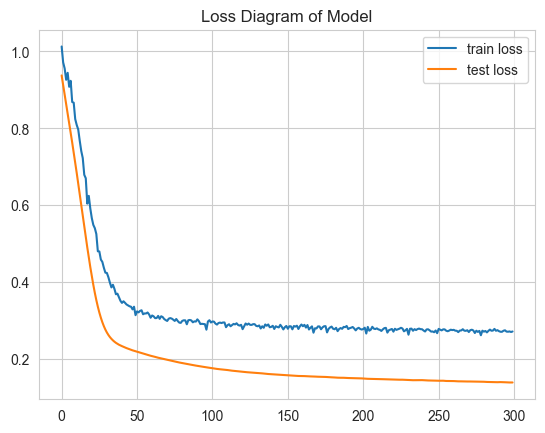

In [32]:
plt.plot(train_loss_history, label = "train loss")
plt.plot(val_loss_history, label = "test loss")
plt.title("Loss Diagram of Model")
plt.legend()

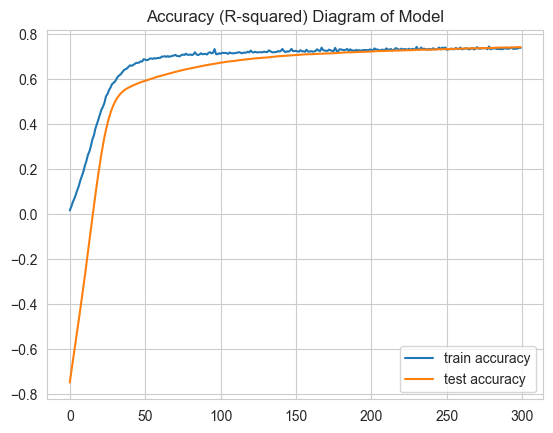

In [33]:
plt.plot(train_r2_history, label = "train accuracy")
plt.plot(val_r2_history, label = "test accuracy")
plt.title("Accuracy (R-squared) Diagram of Model")
plt.legend()

Text(0.5, 1.0, 'Correlation between prediction & true burned area')

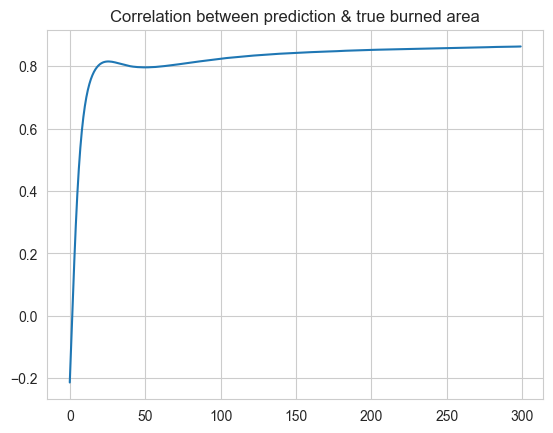

In [34]:
plt.plot(val_rho_history)
plt.title("Correlation between prediction & true burned area")